In [7]:
# 🧪 Relational fragments: upload → feature build (text + numeric + quantifiers) → train → visual CMs → save/zip

import os, io, json, ast, sys, subprocess, shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib

In [8]:
# --------------------------
# Settings
# --------------------------
USE_EMBEDDINGS = True            # set False to skip embeddings variant
EMB_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
SAVE_DIR = Path("models_out"); SAVE_DIR.mkdir(parents=True, exist_ok=True)
SEP_TOKEN = "[SEP]"
MAX_FEATURES = 10_000
RANDOM_STATE = 42
CLASS_NAMES = ["unsat", "sat"]   # 0 -> unsat, 1 -> sat

fname = "relationalsyllogistic.csv"

In [9]:
# --------------------------
# Helpers
# --------------------------
def normalize_label(v):
    if isinstance(v, str):
        s = v.strip().lower()
        if s in {"sat","satisfiable","1","true"}:  return 1
        if s in {"unsat","unsatisfiable","0","false"}:  return 0
    if isinstance(v, (int, np.integer)):
        if v in (0,1): return int(v)
    raise ValueError(f"Unrecognized label: {v!r}")

def parse_sent(cell, sep=SEP_TOKEN):
    if isinstance(cell, list): return f" {sep} ".join(cell)
    if isinstance(cell, str):
        s = cell.strip()
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list) and all(isinstance(x, str) for x in parsed):
                    return f" {sep} ".join(parsed)
            except Exception:
                pass
        return s
    return str(cell)

def safe_literal_eval_maybe_list(x):
    if isinstance(x, (list, tuple)): return x
    if isinstance(x, str):
        s = x.strip()
        if s and (s[0] in "[(" and s[-1] in "])"):
            try:
                return ast.literal_eval(s)
            except Exception:
                return x
    return x

def extract_quantifier_features(qcell):
    """
    qcell can be:
      - 'all' / 'exists'
      - ['exists','all'] (binary pattern)
      - nested lists mixing the above
    Returns dict of counts: singles (all, exists) and pairs (all_all, all_exists, exists_all, exists_exists)
    Also totals: q_single_total, q_pair_total
    """
    singles = {"all":0, "exists":0}
    pairs = {"all_all":0, "all_exists":0, "exists_all":0, "exists_exists":0}

    def rec(node):
        if isinstance(node, str):
            s = node.strip().lower()
            if s in singles:
                singles[s] += 1
        elif isinstance(node, (list, tuple)):
            # count pair if it's exactly two strings of interest
            if len(node) == 2 and all(isinstance(x, str) for x in node):
                a = node[0].strip().lower(); b = node[1].strip().lower()
                if a in singles and b in singles:
                    pairs[f"{a}_{b}"] += 1
            # recurse on children
            for child in node:
                rec(child)
        # ignore other types

    rec(qcell)
    out = {
        "q_all": singles["all"],
        "q_exists": singles["exists"],
        "q_all_all": pairs["all_all"],
        "q_all_exists": pairs["all_exists"],
        "q_exists_all": pairs["exists_all"],
        "q_exists_exists": pairs["exists_exists"],
    }
    out["q_single_total"] = out["q_all"] + out["q_exists"]
    out["q_pair_total"] = out["q_all_all"] + out["q_all_exists"] + out["q_exists_all"] + out["q_exists_exists"]
    return out

def metrics(y_true, y_pred, avg="macro"):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=avg, zero_division=0)
    return {"accuracy": acc, f"precision_{avg}": p, f"recall_{avg}": r, f"f1_{avg}": f1}

def plot_cm(cm, class_names, title, normalize=False, save_path=None):
    cm_plot = cm.astype(float)
    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0.0] = 1.0
        cm_plot = cm_plot / row_sums

    plt.figure(figsize=(4.5, 4))
    im = plt.imshow(cm_plot, interpolation='nearest', cmap='Blues', aspect='equal')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # annotate cells
    thresh = cm_plot.max() / 2.0 if cm_plot.max() > 0 else 0.5
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = f"{cm_plot[i, j]:.2f}" if normalize else f"{int(cm_plot[i, j])}"
            plt.text(j, i, val,
                     ha="center", va="center",
                     color="white" if cm_plot[i, j] > thresh else "black", fontsize=11)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()


In [10]:
# --------------------------
# Load data + build features
# --------------------------
df = pd.read_csv(fname)
label_col = "label" if "label" in df.columns else "sat" if "sat" in df.columns else None
if label_col is None: raise ValueError("No label column found. Expected 'label' or 'sat'.")
if "sentences" not in df.columns: raise ValueError("Expected a 'sentences' column.")

df["y"] = df[label_col].apply(normalize_label).astype(int)
df["text"] = df["sentences"].apply(parse_sent)

# numeric base features (use if present)
base_numeric_cols = [c for c in ["unary","binary","num_clauses","prob"] if c in df.columns]
for c in base_numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# quantifier features (robust to nested lists)
quant_cols = []
if "quantifiers" in df.columns:
    qfeats = []
    for raw in df["quantifiers"]:
        parsed = safe_literal_eval_maybe_list(raw)
        qfeats.append(extract_quantifier_features(parsed))
    qfeats = pd.DataFrame(qfeats)
    df = pd.concat([df, qfeats], axis=1)
    quant_cols = list(qfeats.columns)

# final numeric feature set to fuse with text
numeric_cols = base_numeric_cols + quant_cols

X_full = df[["text"] + numeric_cols].copy()
y = df["y"].to_numpy()

Xtr_df, Xval_df, ytr, yval = train_test_split(X_full, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)


In [11]:
# --------------------------
# TF-IDF pipelines with ColumnTransformer (text + numeric)
# --------------------------
preproc = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(ngram_range=(1,2), max_features=MAX_FEATURES), "text"),
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="constant", fill_value=0.0)),
            ("scale", StandardScaler(with_mean=False)),  # keep sparse compatibility
        ]), numeric_cols) if numeric_cols else ("drop", "drop", numeric_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,  # keeps sparse if large sparse part
)

spaces = {}

spaces["logreg_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", LogisticRegression(solver="liblinear", max_iter=1000, random_state=RANDOM_STATE))]),
    {"clf__C": [0.01, 0.1, 1.0, 10.0]},
    -1
)
spaces["svm_linear_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", LinearSVC())]),
    {"clf__C": [0.1, 1.0]},
    -1
)
spaces["decision_tree_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    {"clf__criterion": ["gini", "entropy"], "clf__max_depth": [10, 20, None]},
    -1
)
spaces["random_forest_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", RandomForestClassifier(random_state=RANDOM_STATE))]),
    {"clf__criterion": ["gini", "entropy"], "clf__n_estimators": [100, 200], "clf__max_features": ["sqrt"]},
    -1
)

summary = {"file": fname, "numeric_cols": numeric_cols, "results": {}}



=== logreg_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 0.01}

Validation report:
              precision    recall  f1-score   support

           0     0.6711    0.1876    0.2933       533
           1     0.7661    0.9666    0.8547      1467

    accuracy                         0.7590      2000
   macro avg     0.7186    0.5771    0.5740      2000
weighted avg     0.7408    0.7590    0.7051      2000



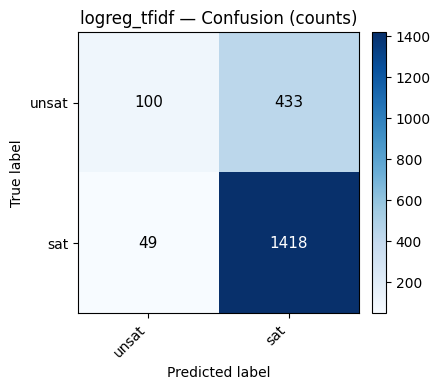

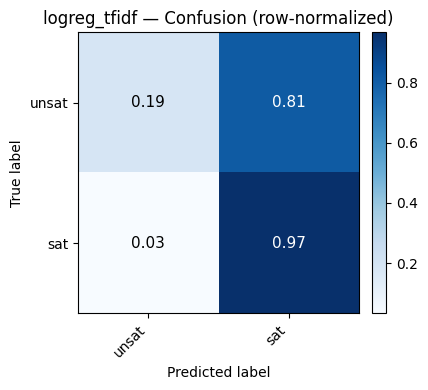


=== svm_linear_tfidf ===
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params: {'clf__C': 0.1}

Validation report:
              precision    recall  f1-score   support

           0     0.6321    0.2514    0.3597       533
           1     0.7768    0.9468    0.8535      1467

    accuracy                         0.7615      2000
   macro avg     0.7045    0.5991    0.6066      2000
weighted avg     0.7383    0.7615    0.7219      2000



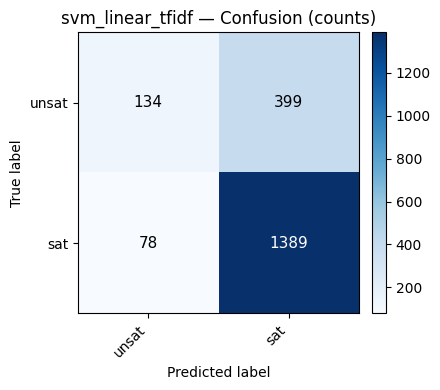

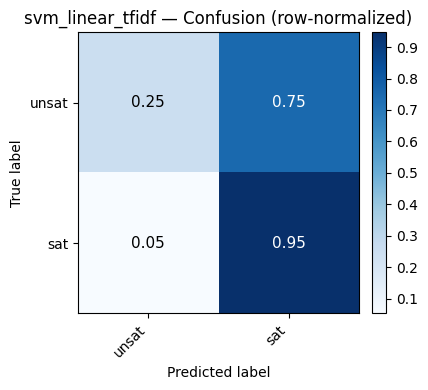


=== decision_tree_tfidf ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 10}

Validation report:
              precision    recall  f1-score   support

           0     0.4615    0.3265    0.3824       533
           1     0.7788    0.8616    0.8181      1467

    accuracy                         0.7190      2000
   macro avg     0.6202    0.5940    0.6003      2000
weighted avg     0.6943    0.7190    0.7020      2000



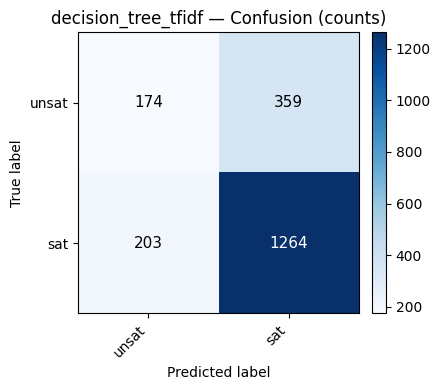

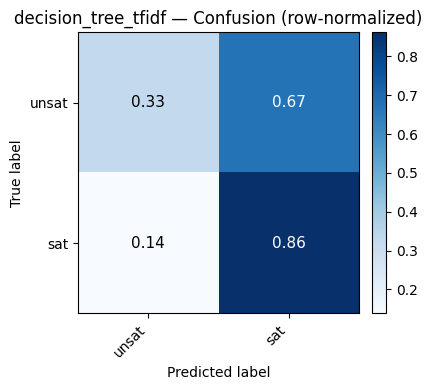


=== random_forest_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__criterion': 'entropy', 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}

Validation report:
              precision    recall  f1-score   support

           0     0.5172    0.0281    0.0534       533
           1     0.7372    0.9905    0.8453      1467

    accuracy                         0.7340      2000
   macro avg     0.6272    0.5093    0.4493      2000
weighted avg     0.6786    0.7340    0.6342      2000



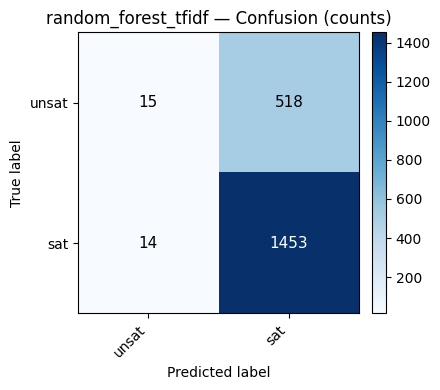

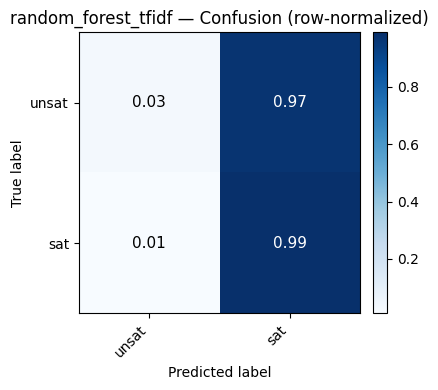

In [12]:
# --------------------------
# Train TF-IDF models
# --------------------------
for name, (pipe, grid, n_jobs) in spaces.items():
    print(f"\n=== {name} ===")
    gs = GridSearchCV(pipe, grid, scoring="f1", cv=3, n_jobs=n_jobs, verbose=1, error_score="raise")
    gs.fit(Xtr_df, ytr)
    best = gs.best_estimator_
    print("Best params:", gs.best_params_)

    yhat = best.predict(Xval_df)
    print("\nValidation report:")
    print(classification_report(yval, yhat, digits=4))
    cm = confusion_matrix(yval, yhat, labels=[0,1])

    # Visual + save CMs
    cm_counts_path = SAVE_DIR / f"cm_{name}_counts.png"
    plot_cm(cm, CLASS_NAMES, f"{name} — Confusion (counts)", normalize=False, save_path=cm_counts_path)
    cm_norm_path = SAVE_DIR / f"cm_{name}_normalized.png"
    plot_cm(cm, CLASS_NAMES, f"{name} — Confusion (row-normalized)", normalize=True, save_path=cm_norm_path)

    model_path = SAVE_DIR / f"{name}.joblib"
    joblib.dump(best, model_path)
    summary["results"][name] = {
        "best_params": gs.best_params_,
        "metrics_macro": metrics(yval, yhat, "macro"),
        "metrics_binary": metrics(yval, yhat, "binary"),
        "confusion_matrix": cm.tolist(),
        "cm_counts_path": str(cm_counts_path),
        "cm_normalized_path": str(cm_norm_path),
        "model_path": str(model_path)
    }


=== logreg_emb (precomputed + numeric/quant features) ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'C': 0.01}

Validation report:
              precision    recall  f1-score   support

           0     0.6604    0.1970    0.3035       533
           1     0.7675    0.9632    0.8543      1467

    accuracy                         0.7590      2000
   macro avg     0.7139    0.5801    0.5789      2000
weighted avg     0.7390    0.7590    0.7075      2000



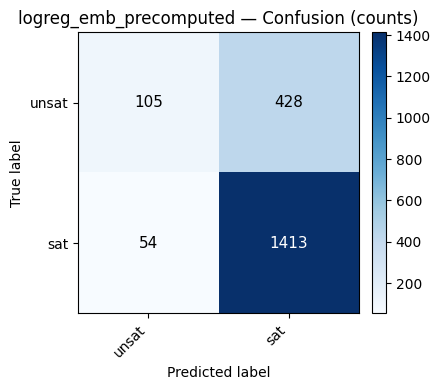

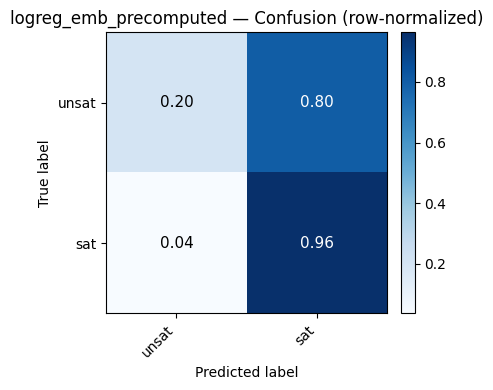

In [13]:
# --------------------------
# Embeddings variant (SAFE): precompute embeddings + concat numeric & quant features
# --------------------------
if USE_EMBEDDINGS:
    try:
        from sentence_transformers import SentenceTransformer
    except Exception:
        print("Installing sentence-transformers ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "sentence-transformers"])
        from sentence_transformers import SentenceTransformer

    print("\n=== logreg_emb (precomputed + numeric/quant features) ===")
    st_model = SentenceTransformer(EMB_MODEL_NAME)

    def embed(texts, batch_size=256):
        return st_model.encode(
            list(texts),
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=False
        )

    # Precompute embeddings
    Xtr_emb = embed(Xtr_df["text"])
    Xval_emb = embed(Xval_df["text"])

    # Numeric/quant arrays (dense)
    if numeric_cols:
        num_imputer = SimpleImputer(strategy="constant", fill_value=0.0)
        num_scaler  = StandardScaler(with_mean=True)
        Xtr_num = num_imputer.fit_transform(Xtr_df[numeric_cols].to_numpy(dtype=float))
        Xval_num = num_imputer.transform(Xval_df[numeric_cols].to_numpy(dtype=float))
        Xtr_num_s = num_scaler.fit_transform(Xtr_num)
        Xval_num_s = num_scaler.transform(Xval_num)
        # Concat emb + numeric
        Xtr_emb_aug = np.hstack([Xtr_emb, Xtr_num_s])
        Xval_emb_aug = np.hstack([Xval_emb, Xval_num_s])
        emb_bundle_extras = {"num_imputer": num_imputer, "num_scaler": num_scaler, "numeric_cols": numeric_cols}
    else:
        Xtr_emb_aug, Xval_emb_aug = Xtr_emb, Xval_emb
        emb_bundle_extras = {"numeric_cols": []}

    # Grid search on classifier
    logreg = LogisticRegression(solver="liblinear", max_iter=1000, random_state=RANDOM_STATE)
    param_grid = {"C": [0.01, 0.1, 1.0, 10.0]}
    gs_emb = GridSearchCV(logreg, param_grid, scoring="f1", cv=3, n_jobs=-1, verbose=1, error_score="raise")
    gs_emb.fit(Xtr_emb_aug, ytr)
    print("Best params:", gs_emb.best_params_)

    yhat = gs_emb.predict(Xval_emb_aug)
    print("\nValidation report:")
    print(classification_report(yval, yhat, digits=4))
    cm = confusion_matrix(yval, yhat, labels=[0,1])

    # Visual + save
    cm_counts_path = SAVE_DIR / f"cm_logreg_emb_precomputed_counts.png"
    plot_cm(cm, CLASS_NAMES, "logreg_emb_precomputed — Confusion (counts)", normalize=False, save_path=cm_counts_path)
    cm_norm_path = SAVE_DIR / f"cm_logreg_emb_precomputed_normalized.png"
    plot_cm(cm, CLASS_NAMES, "logreg_emb_precomputed — Confusion (row-normalized)", normalize=True, save_path=cm_norm_path)

    # Save bundle: embedding model name + clf + (imputer/scaler for numeric)
    bundle = {"clf": gs_emb.best_estimator_, "embedding_model": EMB_MODEL_NAME}
    bundle.update(emb_bundle_extras)
    model_path = SAVE_DIR / "logreg_emb_precomputed.joblib"
    joblib.dump(bundle, model_path)

    summary["results"]["logreg_emb_precomputed"] = {
        "best_params": gs_emb.best_params_,
        "metrics_macro": metrics(yval, yhat, "macro"),
        "metrics_binary": metrics(yval, yhat, "binary"),
        "confusion_matrix": cm.tolist(),
        "cm_counts_path": str(cm_counts_path),
        "cm_normalized_path": str(cm_norm_path),
        "model_path": str(model_path)
    }

In [14]:
# --------------------------
# Save summary + zip for download
# --------------------------
rep_path = SAVE_DIR / "report.json"
with open(rep_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print(f"\nSaved models, CMs & report to: {SAVE_DIR.resolve()}")
print(json.dumps(summary, indent=2)[:1200], "...")

zip_path = shutil.make_archive("models_out", "zip", root_dir=SAVE_DIR)
print(f"\nZipped: {zip_path}")
try:
    files.download(zip_path)
except Exception:
    print("If the download prompt doesn't appear, use the Files pane to download 'models_out.zip'.")



Saved models, CMs & report to: /content/models_out
{
  "file": "relationalsyllogistic.csv",
  "numeric_cols": [
    "unary",
    "binary",
    "num_clauses",
    "prob",
    "q_all",
    "q_exists",
    "q_all_all",
    "q_all_exists",
    "q_exists_all",
    "q_exists_exists",
    "q_single_total",
    "q_pair_total"
  ],
  "results": {
    "logreg_tfidf": {
      "best_params": {
        "clf__C": 0.01
      },
      "metrics_macro": {
        "accuracy": 0.759,
        "precision_macro": 0.718606666449117,
        "recall_macro": 0.5771078805644121,
        "f1_macro": 0.5739934490444903
      },
      "metrics_binary": {
        "accuracy": 0.759,
        "precision_binary": 0.7660723933009185,
        "recall_binary": 0.9665985003408316,
        "f1_binary": 0.8547317661241712
      },
      "confusion_matrix": [
        [
          100,
          433
        ],
        [
          49,
          1418
        ]
      ],
      "cm_counts_path": "models_out/cm_logreg_tfidf_counts.pn


=== logreg_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 0.01} | refit metric: f1_macro

Validation report (default threshold):
              precision    recall  f1-score   support

           0     0.4454    0.6660    0.5338       533
           1     0.8520    0.6987    0.7678      1467

    accuracy                         0.6900      2000
   macro avg     0.6487    0.6824    0.6508      2000
weighted avg     0.7437    0.6900    0.7054      2000



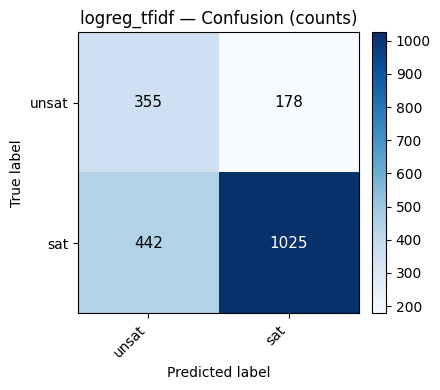

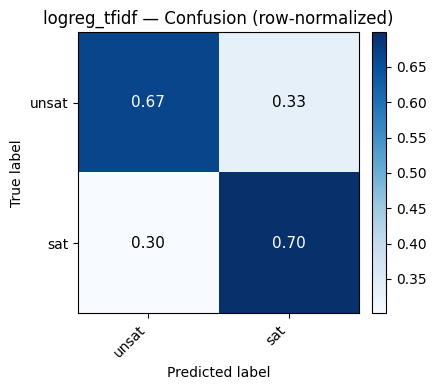


Validation report (threshold-tuned via proba, thr=0.4500, macro-F1=0.6723):
              precision    recall  f1-score   support

           0     0.4952    0.5797    0.5341       533
           1     0.8372    0.7853    0.8104      1467

    accuracy                         0.7305      2000
   macro avg     0.6662    0.6825    0.6723      2000
weighted avg     0.7461    0.7305    0.7368      2000



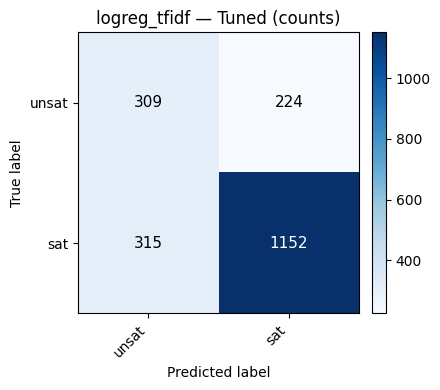

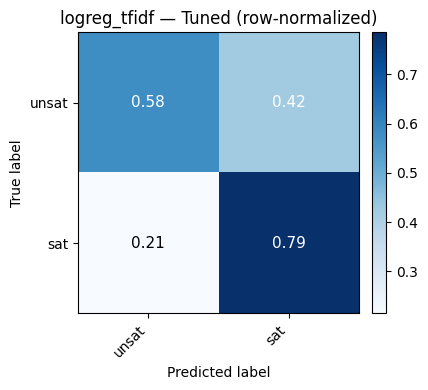


=== svm_linear_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 0.01} | refit metric: f1_macro

Validation report (default threshold):
              precision    recall  f1-score   support

           0     0.4384    0.6473    0.5227       533
           1     0.8450    0.6987    0.7649      1467

    accuracy                         0.6850      2000
   macro avg     0.6417    0.6730    0.6438      2000
weighted avg     0.7366    0.6850    0.7004      2000



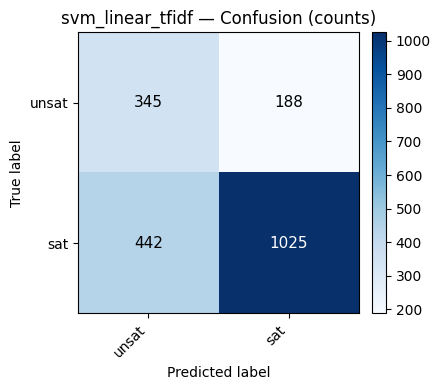

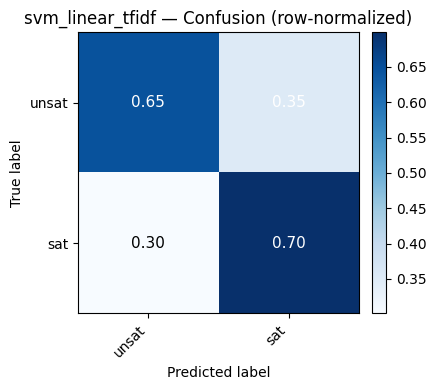


Validation report (threshold-tuned via decision, thr=-0.2111, macro-F1=0.6743):
              precision    recall  f1-score   support

           0     0.5616    0.4615    0.5067       533
           1     0.8163    0.8691    0.8419      1467

    accuracy                         0.7605      2000
   macro avg     0.6890    0.6653    0.6743      2000
weighted avg     0.7484    0.7605    0.7525      2000



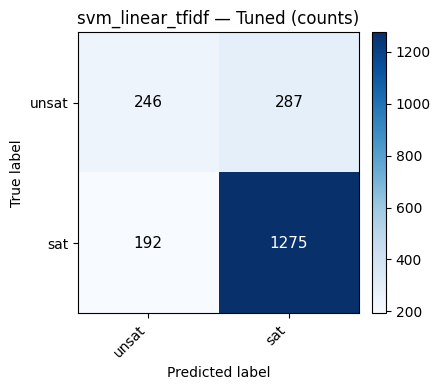

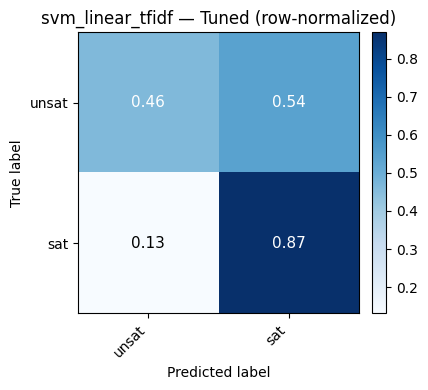


=== decision_tree_tfidf ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 20} | refit metric: f1_macro

Validation report (default threshold):
              precision    recall  f1-score   support

           0     0.3885    0.4803    0.4295       533
           1     0.7934    0.7253    0.7578      1467

    accuracy                         0.6600      2000
   macro avg     0.5910    0.6028    0.5937      2000
weighted avg     0.6855    0.6600    0.6703      2000



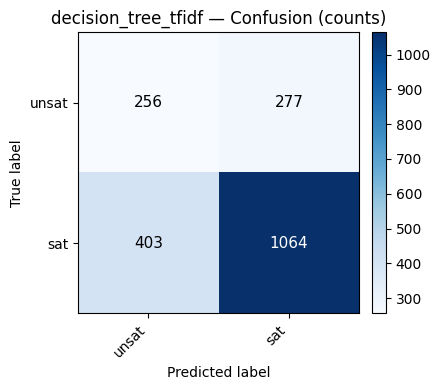

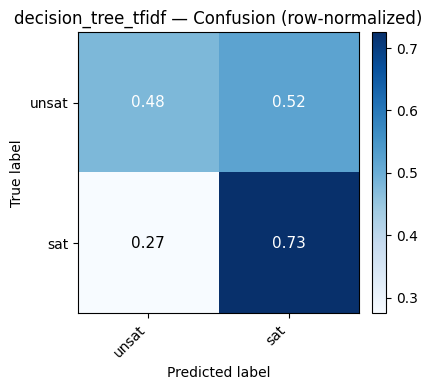


Validation report (threshold-tuned via proba, thr=0.2000, macro-F1=0.5989):
              precision    recall  f1-score   support

           0     0.3984    0.4672    0.4301       533
           1     0.7935    0.7437    0.7678      1467

    accuracy                         0.6700      2000
   macro avg     0.5959    0.6054    0.5989      2000
weighted avg     0.6882    0.6700    0.6778      2000



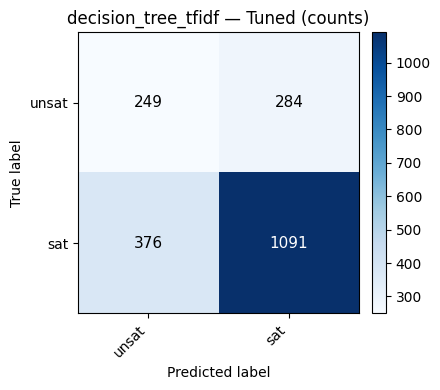

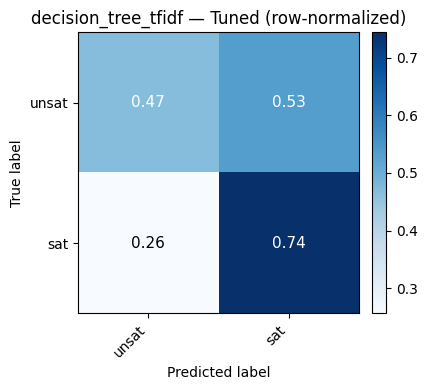


=== random_forest_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 100} | refit metric: f1_macro

Validation report (default threshold):
              precision    recall  f1-score   support

           0     0.5802    0.0882    0.1531       533
           1     0.7467    0.9768    0.8464      1467

    accuracy                         0.7400      2000
   macro avg     0.6635    0.5325    0.4998      2000
weighted avg     0.7024    0.7400    0.6617      2000



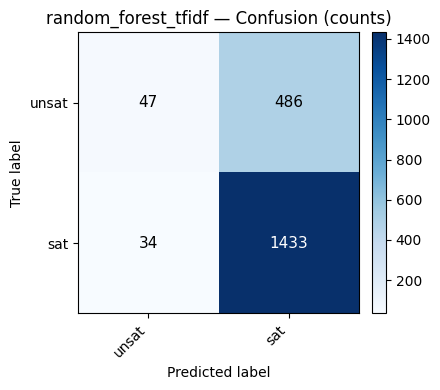

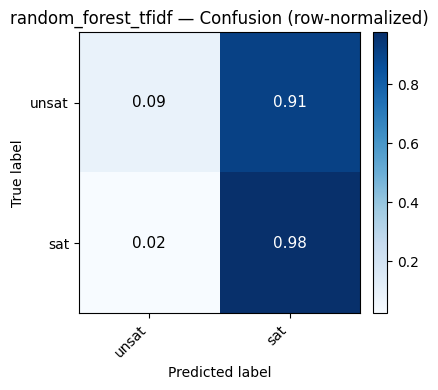


Validation report (threshold-tuned via proba, thr=0.6500, macro-F1=0.6345):
              precision    recall  f1-score   support

           0     0.4869    0.4184    0.4501       533
           1     0.7990    0.8398    0.8189      1467

    accuracy                         0.7275      2000
   macro avg     0.6429    0.6291    0.6345      2000
weighted avg     0.7158    0.7275    0.7206      2000



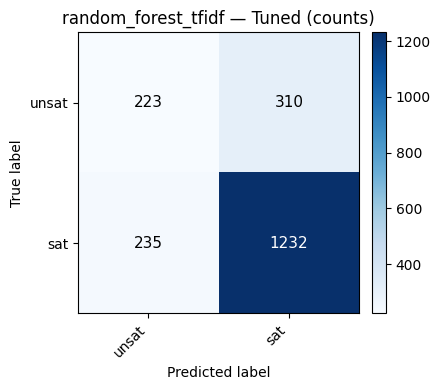

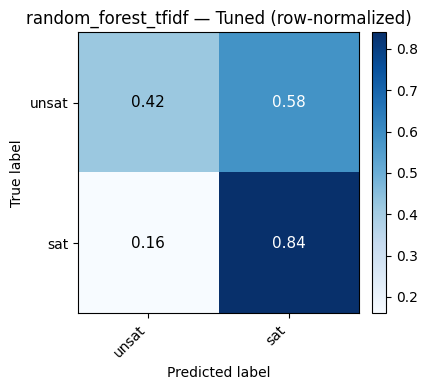


=== logreg_emb_precomputed (with numeric/quant features) ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'C': 0.1} | refit metric: f1_macro

Validation report (default threshold):
              precision    recall  f1-score   support

           0     0.4425    0.6642    0.5311       533
           1     0.8508    0.6960    0.7657      1467

    accuracy                         0.6875      2000
   macro avg     0.6467    0.6801    0.6484      2000
weighted avg     0.7420    0.6875    0.7032      2000



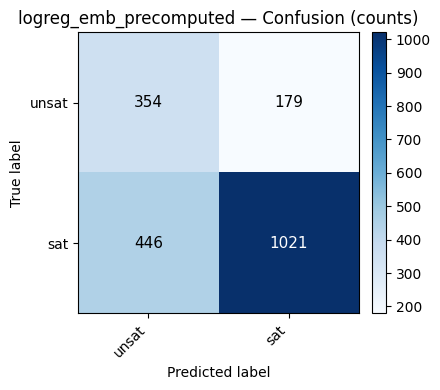

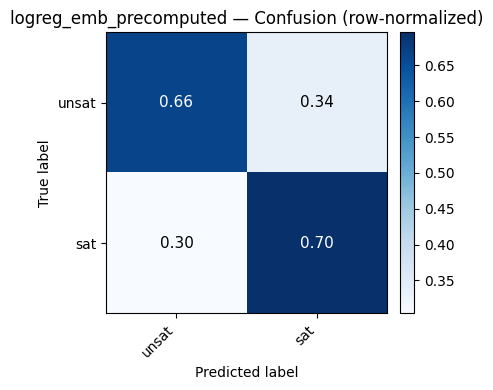


Validation report (threshold-tuned via proba, thr=0.4000, macro-F1=0.6736):
              precision    recall  f1-score   support

           0     0.5249    0.5141    0.5194       533
           1     0.8248    0.8309    0.8278      1467

    accuracy                         0.7465      2000
   macro avg     0.6748    0.6725    0.6736      2000
weighted avg     0.7449    0.7465    0.7457      2000



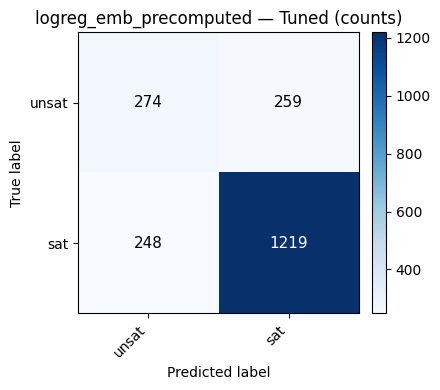

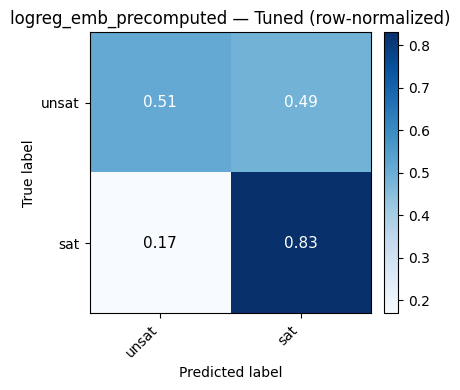


Saved models, CMs & report to: /content/models_out
{
  "file": "relationalsyllogistic.csv",
  "numeric_cols": [
    "unary",
    "binary",
    "num_clauses",
    "prob",
    "q_all",
    "q_exists",
    "q_all_all",
    "q_all_exists",
    "q_exists_all",
    "q_exists_exists",
    "q_single_total",
    "q_pair_total"
  ],
  "results": {
    "logreg_tfidf": {
      "best_params": {
        "clf__C": 0.01
      },
      "refit_metric": "f1_macro",
      "metrics_macro_default": {
        "accuracy": 0.69,
        "precision_macro": 0.6487284507259663,
        "recall_macro": 0.6823730578032539,
        "f1_macro": 0.650812424319225
      },
      "metrics_binary_default": {
        "accuracy": 0.69,
        "precision_binary": 0.8520365752285952,
        "recall_binary": 0.6987048398091343,
        "f1_binary": 0.7677902621722846
      },
      "confusion_matrix_default": [
        [
          355,
          178
        ],
        [
          442,
          1025
        ]
      ],
    

In [1]:
# 🚀 All-in-one Colab cell: relational fragments → features → class-balanced training → threshold tuning → visual CMs → save/zip


# ====== SETTINGS ======
USE_EMBEDDINGS   = True     # set False to skip MiniLM embeddings variant
USE_OVERSAMPLING = False    # set True to oversample minority (training folds only)
EMB_MODEL_NAME   = "sentence-transformers/all-MiniLM-L6-v2"
SEP_TOKEN        = "[SEP]"
MAX_FEATURES     = 10_000
RANDOM_STATE     = 42
CLASS_NAMES      = ["unsat", "sat"]  # 0 -> unsat, 1 -> sat

# ====== IMPORTS ======
import os, io, json, ast, sys, subprocess, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support,
    balanced_accuracy_score, f1_score, make_scorer
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib

# Optional: oversampling
if USE_OVERSAMPLING:
    try:
        from imblearn.over_sampling import RandomOverSampler
    except Exception:
        !pip -q install imbalanced-learn
        from imblearn.over_sampling import RandomOverSampler

SAVE_DIR = Path("models_out"); SAVE_DIR.mkdir(parents=True, exist_ok=True)

fname = "relationalsyllogistic.csv"

# ====== HELPERS ======
def normalize_label(v):
    if isinstance(v, str):
        s = v.strip().lower()
        if s in {"sat","satisfiable","1","true"}:  return 1
        if s in {"unsat","unsatisfiable","0","false"}:  return 0
    if isinstance(v, (int, np.integer)):
        if v in (0,1): return int(v)
    raise ValueError(f"Unrecognized label: {v!r}")

def parse_sent(cell, sep=SEP_TOKEN):
    if isinstance(cell, list): return f" {sep} ".join(cell)
    if isinstance(cell, str):
        s = cell.strip()
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list) and all(isinstance(x, str) for x in parsed):
                    return f" {sep} ".join(parsed)
            except Exception:
                pass
        return s
    return str(cell)

def safe_literal_eval_maybe_list(x):
    if isinstance(x, (list, tuple)): return x
    if isinstance(x, str):
        s = x.strip()
        if s and (s[0] in "[(" and s[-1] in "])"):
            try:
                return ast.literal_eval(s)
            except Exception:
                return x
    return x

def extract_quantifier_features(qcell):
    """
    qcell examples:
      'all', 'exists', ['exists','all'], nested lists, etc.
    Returns counts of singles & ordered pairs + totals.
    """
    singles = {"all":0, "exists":0}
    pairs = {"all_all":0, "all_exists":0, "exists_all":0, "exists_exists":0}

    def rec(node):
        if isinstance(node, str):
            s = node.strip().lower()
            if s in singles: singles[s] += 1
        elif isinstance(node, (list, tuple)):
            if len(node) == 2 and all(isinstance(x, str) for x in node):
                a = node[0].strip().lower(); b = node[1].strip().lower()
                if a in singles and b in singles:
                    pairs[f"{a}_{b}"] += 1
            for child in node:
                rec(child)
        # ignore other types

    rec(qcell)
    out = {
        "q_all": singles["all"],
        "q_exists": singles["exists"],
        "q_all_all": pairs["all_all"],
        "q_all_exists": pairs["all_exists"],
        "q_exists_all": pairs["exists_all"],
        "q_exists_exists": pairs["exists_exists"],
    }
    out["q_single_total"] = out["q_all"] + out["q_exists"]
    out["q_pair_total"] = out["q_all_all"] + out["q_all_exists"] + out["q_exists_all"] + out["q_exists_exists"]
    return out

def metrics(y_true, y_pred, avg="macro"):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=avg, zero_division=0)
    return {"accuracy": acc, f"precision_{avg}": p, f"recall_{avg}": r, f"f1_{avg}": f1}

def plot_cm(cm, class_names, title, normalize=False, save_path=None):
    cm_plot = cm.astype(float)
    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0.0] = 1.0
        cm_plot = cm_plot / row_sums

    plt.figure(figsize=(4.5, 4))
    im = plt.imshow(cm_plot, interpolation='nearest', cmap='Blues', aspect='equal')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    thresh = cm_plot.max() / 2.0 if cm_plot.max() > 0 else 0.5
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = f"{cm_plot[i, j]:.2f}" if normalize else f"{int(cm_plot[i, j])}"
            plt.text(j, i, val,
                     ha="center", va="center",
                     color="white" if cm_plot[i, j] > thresh else "black", fontsize=11)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

def tune_threshold(scores, y_true, use_proba=True):
    """
    Sweep thresholds and pick the one that maximizes macro-F1.
    - scores: prob of class 1 (if use_proba) or decision_function values
    """
    if use_proba:
        thr_grid = np.linspace(0.1, 0.9, 33)
    else:
        thr_grid = np.percentile(scores, np.linspace(5, 95, 33))

    best_t, best_f1 = None, -1
    for t in thr_grid:
        y_pred = (scores >= t).astype(int)
        f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
        if f1m > best_f1:
            best_f1, best_t = f1m, t
    return best_t, best_f1

SCORING = {"f1_macro": "f1_macro", "balanced_accuracy": make_scorer(balanced_accuracy_score)}
REFIT   = "f1_macro"

# ====== LOAD + FEATURE ENGINEERING ======
df = pd.read_csv(fname)
label_col = "label" if "label" in df.columns else "sat" if "sat" in df.columns else None
if label_col is None: raise ValueError("No label column found. Expected 'label' or 'sat'.")
if "sentences" not in df.columns: raise ValueError("Expected a 'sentences' column.")

df["y"] = df[label_col].apply(normalize_label).astype(int)
df["text"] = df["sentences"].apply(parse_sent)

# numeric base features
base_numeric_cols = [c for c in ["unary","binary","num_clauses","prob"] if c in df.columns]
for c in base_numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# quantifier features (nested-list aware)
quant_cols = []
if "quantifiers" in df.columns:
    qfeats = []
    for raw in df["quantifiers"]:
        parsed = safe_literal_eval_maybe_list(raw)
        qfeats.append(extract_quantifier_features(parsed))
    qfeats = pd.DataFrame(qfeats)
    df = pd.concat([df, qfeats], axis=1)
    quant_cols = list(qfeats.columns)

numeric_cols = base_numeric_cols + quant_cols

X_full = df[["text"] + numeric_cols].copy()
y = df["y"].to_numpy()

Xtr_df, Xval_df, ytr, yval = train_test_split(X_full, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# Optional oversampling (training folds only)
if USE_OVERSAMPLING:
    ros = RandomOverSampler(random_state=RANDOM_STATE)
    Xtr_df, ytr = ros.fit_resample(Xtr_df, ytr)
    print("Oversampled training shape:", Xtr_df.shape, "class balance:", np.bincount(ytr))

# ====== TF-IDF + NUMERIC ColumnTransformer ======
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

preproc = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(ngram_range=(1,2), max_features=MAX_FEATURES), "text"),
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="constant", fill_value=0.0)),
            ("scale", StandardScaler(with_mean=False)),  # OK with sparse outputs
        ]), numeric_cols) if numeric_cols else ("drop", "drop", numeric_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

spaces = {}

spaces["logreg_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", LogisticRegression(
                  solver="liblinear", max_iter=1000, random_state=RANDOM_STATE,
                  class_weight="balanced"
              ))]),
    {"clf__C": [0.01, 0.1, 1.0, 10.0]},
    -1
)

spaces["svm_linear_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", LinearSVC(class_weight="balanced"))]),
    {"clf__C": [0.01, 0.1, 1.0, 10.0]},
    -1
)

spaces["decision_tree_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))]),
    {"clf__criterion": ["gini", "entropy"], "clf__max_depth": [10, 20, None]},
    -1
)

spaces["random_forest_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", RandomForestClassifier(
                  random_state=RANDOM_STATE, class_weight="balanced_subsample"
              ))]),
    {"clf__criterion": ["gini", "entropy"], "clf__n_estimators": [100, 200], "clf__max_features": ["sqrt"]},
    -1
)

summary = {"file": fname, "numeric_cols": numeric_cols, "results": {}}

# ====== TRAIN TF-IDF MODELS (with macro scoring) + THRESHOLD TUNING ======
for name, (pipe, grid, n_jobs) in spaces.items():
    print(f"\n=== {name} ===")
    gs = GridSearchCV(
        pipe, grid, scoring=SCORING, refit=REFIT,
        cv=3, n_jobs=n_jobs, verbose=1, error_score="raise"
    )
    gs.fit(Xtr_df, ytr)
    best = gs.best_estimator_
    print("Best params:", gs.best_params_, "| refit metric:", REFIT)

    # Default predictions
    yhat = best.predict(Xval_df)

    # Threshold tuning
    tuned_info = None
    if hasattr(best, "predict_proba"):
        p1 = best.predict_proba(Xval_df)[:, 1]
        thr, f1m = tune_threshold(p1, yval, use_proba=True)
        yhat_t = (p1 >= thr).astype(int)
        tuned_info = ("proba", thr, f1m, yhat_t)
    elif hasattr(best, "decision_function"):
        s = best.decision_function(Xval_df)
        thr, f1m = tune_threshold(s, yval, use_proba=False)
        yhat_t = (s >= thr).astype(int)
        tuned_info = ("decision", thr, f1m, yhat_t)

    # Reports + CMs (default)
    print("\nValidation report (default threshold):")
    print(classification_report(yval, yhat, digits=4))
    cm = confusion_matrix(yval, yhat, labels=[0,1])
    cm_counts_path = SAVE_DIR / f"cm_{name}_counts.png"
    cm_norm_path   = SAVE_DIR / f"cm_{name}_normalized.png"
    plot_cm(cm, CLASS_NAMES, f"{name} — Confusion (counts)", normalize=False, save_path=cm_counts_path)
    plot_cm(cm, CLASS_NAMES, f"{name} — Confusion (row-normalized)", normalize=True, save_path=cm_norm_path)

    # Reports + CMs (tuned)
    tuned_summary = None
    if tuned_info is not None:
        mode, thr, f1m, yhat_t = tuned_info
        print(f"\nValidation report (threshold-tuned via {mode}, thr={thr:.4f}, macro-F1={f1m:.4f}):")
        print(classification_report(yval, yhat_t, digits=4))
        cm_t = confusion_matrix(yval, yhat_t, labels=[0,1])
        cm_t_counts_path = SAVE_DIR / f"cm_{name}_tuned_counts.png"
        cm_t_norm_path   = SAVE_DIR / f"cm_{name}_tuned_normalized.png"
        plot_cm(cm_t, CLASS_NAMES, f"{name} — Tuned (counts)", normalize=False, save_path=cm_t_counts_path)
        plot_cm(cm_t, CLASS_NAMES, f"{name} — Tuned (row-normalized)", normalize=True, save_path=cm_t_norm_path)
        tuned_summary = {
            "mode": mode, "threshold": float(thr),
            "metrics_macro": metrics(yval, yhat_t, "macro"),
            "metrics_binary": metrics(yval, yhat_t, "binary"),
            "confusion_matrix": cm_t.tolist(),
            "cm_counts_path": str(cm_t_counts_path),
            "cm_normalized_path": str(cm_t_norm_path)
        }

    # save model
    model_path = SAVE_DIR / f"{name}.joblib"
    joblib.dump(best, model_path)

    # record summary
    summary["results"][name] = {
        "best_params": gs.best_params_,
        "refit_metric": REFIT,
        "metrics_macro_default": metrics(yval, yhat, "macro"),
        "metrics_binary_default": metrics(yval, yhat, "binary"),
        "confusion_matrix_default": cm.tolist(),
        "cm_counts_path_default": str(cm_counts_path),
        "cm_normalized_path_default": str(cm_norm_path),
        "tuned": tuned_summary,
        "model_path": str(model_path)
    }

# ====== EMBEDDINGS VARIANT (precompute MiniLM + concat numeric) ======
if USE_EMBEDDINGS:
    try:
        from sentence_transformers import SentenceTransformer
    except Exception:
        print("Installing sentence-transformers ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "sentence-transformers"])
        from sentence_transformers import SentenceTransformer

    print("\n=== logreg_emb_precomputed (with numeric/quant features) ===")
    st_model = SentenceTransformer(EMB_MODEL_NAME)

    def embed(texts, batch_size=256):
        return st_model.encode(
            list(texts),
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=False
        )

    # Precompute embeddings for text
    Xtr_emb = embed(Xtr_df["text"])
    Xval_emb = embed(Xval_df["text"])

    # Numeric/quant arrays (dense)
    if numeric_cols:
        num_imputer = SimpleImputer(strategy="constant", fill_value=0.0)
        num_scaler  = StandardScaler(with_mean=True)
        Xtr_num = num_imputer.fit_transform(Xtr_df[numeric_cols].to_numpy(dtype=float))
        Xval_num = num_imputer.transform(Xval_df[numeric_cols].to_numpy(dtype=float))
        Xtr_num_s = num_scaler.fit_transform(Xtr_num)
        Xval_num_s = num_scaler.transform(Xval_num)
        Xtr_emb_aug = np.hstack([Xtr_emb, Xtr_num_s])
        Xval_emb_aug = np.hstack([Xval_emb, Xval_num_s])
        emb_bundle_extras = {"num_imputer": num_imputer, "num_scaler": num_scaler, "numeric_cols": numeric_cols}
    else:
        Xtr_emb_aug, Xval_emb_aug = Xtr_emb, Xval_emb
        emb_bundle_extras = {"numeric_cols": []}

    # Optional oversampling
    if USE_OVERSAMPLING:
        ros = RandomOverSampler(random_state=RANDOM_STATE)
        Xtr_emb_aug, ytr = ros.fit_resample(Xtr_emb_aug, ytr)
        print("Oversampled (emb) training shape:", Xtr_emb_aug.shape, "class balance:", np.bincount(ytr))

    # Grid search on class-balanced Logistic Regression
    logreg = LogisticRegression(
        solver="liblinear", max_iter=1000, random_state=RANDOM_STATE,
        class_weight="balanced"
    )
    param_grid = {"C": [0.01, 0.1, 1.0, 10.0]}
    gs_emb = GridSearchCV(logreg, param_grid, scoring=SCORING, refit=REFIT, cv=3, n_jobs=-1, verbose=1, error_score="raise")
    gs_emb.fit(Xtr_emb_aug, ytr)
    print("Best params:", gs_emb.best_params_, "| refit metric:", REFIT)

    # Default predictions
    yhat = gs_emb.predict(Xval_emb_aug)

    # Threshold tuning (use predict_proba)
    p1 = gs_emb.predict_proba(Xval_emb_aug)[:, 1]
    thr, f1m = tune_threshold(p1, yval, use_proba=True)
    yhat_t = (p1 >= thr).astype(int)

    # Reports + CMs
    print("\nValidation report (default threshold):")
    print(classification_report(yval, yhat, digits=4))
    cm = confusion_matrix(yval, yhat, labels=[0,1])
    cm_counts_path = SAVE_DIR / f"cm_logreg_emb_precomputed_counts.png"
    cm_norm_path   = SAVE_DIR / f"cm_logreg_emb_precomputed_normalized.png"
    plot_cm(cm, CLASS_NAMES, "logreg_emb_precomputed — Confusion (counts)", normalize=False, save_path=cm_counts_path)
    plot_cm(cm, CLASS_NAMES, "logreg_emb_precomputed — Confusion (row-normalized)", normalize=True, save_path=cm_norm_path)

    print(f"\nValidation report (threshold-tuned via proba, thr={thr:.4f}, macro-F1={f1m:.4f}):")
    print(classification_report(yval, yhat_t, digits=4))
    cm_t = confusion_matrix(yval, yhat_t, labels=[0,1])
    cm_t_counts_path = SAVE_DIR / f"cm_logreg_emb_precomputed_tuned_counts.png"
    cm_t_norm_path   = SAVE_DIR / f"cm_logreg_emb_precomputed_tuned_normalized.png"
    plot_cm(cm_t, CLASS_NAMES, "logreg_emb_precomputed — Tuned (counts)", normalize=False, save_path=cm_t_counts_path)
    plot_cm(cm_t, CLASS_NAMES, "logreg_emb_precomputed — Tuned (row-normalized)", normalize=True, save_path=cm_t_norm_path)

    # Save bundle
    bundle = {"clf": gs_emb.best_estimator_, "embedding_model": EMB_MODEL_NAME}
    bundle.update(emb_bundle_extras)
    model_path = SAVE_DIR / "logreg_emb_precomputed.joblib"
    joblib.dump(bundle, model_path)

    summary["results"]["logreg_emb_precomputed"] = {
        "best_params": gs_emb.best_params_,
        "refit_metric": REFIT,
        "metrics_macro_default": metrics(yval, yhat, "macro"),
        "metrics_binary_default": metrics(yval, yhat, "binary"),
        "confusion_matrix_default": cm.tolist(),
        "cm_counts_path_default": str(cm_counts_path),
        "cm_normalized_path_default": str(cm_norm_path),
        "tuned": {
            "mode": "proba", "threshold": float(thr),
            "metrics_macro": metrics(yval, yhat_t, "macro"),
            "metrics_binary": metrics(yval, yhat_t, "binary"),
            "confusion_matrix": cm_t.tolist(),
            "cm_counts_path": str(cm_t_counts_path),
            "cm_normalized_path": str(cm_t_norm_path)
        },
        "model_path": str(model_path)
    }

# ====== SAVE SUMMARY + ZIP ======
rep_path = SAVE_DIR / "report.json"
with open(rep_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print(f"\nSaved models, CMs & report to: {SAVE_DIR.resolve()}")
print(json.dumps(summary, indent=2)[:1200], "...")

zip_path = shutil.make_archive("models_out", "zip", root_dir=SAVE_DIR)
print(f"\nZipped: {zip_path}")
try:
    files.download(zip_path)
except Exception:
    print("If the download prompt doesn't appear, use the Files pane to download 'models_out.zip'.")
